In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
from torch.utils.data import DataLoader,Dataset
import torch.nn as nn
import torch.nn.functional as F
import math
import h5py

torch.manual_seed(0)

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
mu = torch.tensor(0.01)

In [3]:
class DeepONet(nn.Module):
    def __init__(self):
        super(DeepONet,self).__init__()
        self.Branch_L1 = nn.Linear(201,100)
        self.Branch_L2 = nn.Linear(100,100)
        self.Branch_L3 = nn.Linear(100,100)
        self.Branch_L4 = nn.Linear(100,100)
        self.Branch_L5 = nn.Linear(100,100)
        self.Branch_L6 = nn.Linear(100,100)
        self.Branch_L7 = nn.Linear(100,100)

        self.Trunk_L1 = nn.Linear(2,20)
        self.Trunk_L2 = nn.Linear(20,50)
        self.Trunk_L3 = nn.Linear(50,100)
        self.Trunk_L4 = nn.Linear(100,100)
        self.Trunk_L5 = nn.Linear(100,100)
        self.Trunk_L6 = nn.Linear(100,100)
        self.Trunk_L7 = nn.Linear(100,100)

    def forward(self,y_0,x_loc_and_time):
        # Branch
        b = F.tanh(self.Branch_L1(y_0))
        b = F.tanh(self.Branch_L2(b))
        b = F.tanh(self.Branch_L3(b))
        b = F.tanh(self.Branch_L4(b))
        b = F.tanh(self.Branch_L5(b))
        b = F.tanh(self.Branch_L6(b))
        b = self.Branch_L7(b)

        tr = F.tanh(self.Trunk_L1(x_loc_and_time))
        tr = F.tanh(self.Trunk_L2(tr))
        tr = F.tanh(self.Trunk_L3(tr))
        tr = F.tanh(self.Trunk_L4(tr))
        tr = F.tanh(self.Trunk_L5(tr))
        tr = F.tanh(self.Trunk_L6(tr))
        tr = self.Trunk_L7(tr)

        #output = torch.matmul(b,tr.t()).sum(dim=0)
        output = torch.sum(b * tr, dim=1)

        return output
    
# model = torch.load("model_burgers_1.pt",weights_only=False)

model = DeepONet().to(device)
model.load_state_dict(torch.load('model_burgers_4.pt'))
#model.eval().to(device)

In [4]:
model.Branch_L1.bias


Parameter containing:
tensor([-0.0458,  0.0162,  0.0302, -0.0406,  0.0615,  0.0076, -0.0645, -0.0679,
         0.0229,  0.0180, -0.0448,  0.0252,  0.0458,  0.0528, -0.0098, -0.0229,
         0.0254, -0.0394, -0.0641, -0.0168,  0.0085,  0.0213,  0.0551, -0.0100,
        -0.0440,  0.0012,  0.0196,  0.0656,  0.0476, -0.0642,  0.0139,  0.0381,
        -0.0237,  0.0330, -0.0052, -0.0292, -0.0303,  0.0403,  0.0586,  0.0621,
         0.0115, -0.0021,  0.0432,  0.0558, -0.0051, -0.0204, -0.0440,  0.0307,
        -0.0613,  0.0249, -0.0597,  0.0664, -0.0667, -0.0420, -0.0100, -0.0182,
        -0.0115, -0.0384, -0.0116, -0.0472, -0.0679, -0.0677,  0.0561,  0.0172,
         0.0640,  0.0087, -0.0233, -0.0102, -0.0669,  0.0643,  0.0458, -0.0304,
         0.0184,  0.0453, -0.0326, -0.0428, -0.0468, -0.0689,  0.0691,  0.0012,
        -0.0094,  0.0063, -0.0524,  0.0536, -0.0683,  0.0550, -0.0446,  0.0305,
        -0.0002, -0.0679,  0.0585,  0.0417,  0.0184,  0.0326, -0.0656,  0.0179,
         0.0274,  

In [5]:
# database = pd.read_csv('minus_sin_pix.csv',index_col=0).dropna().to_numpy(dtype='float32')
#database = pd.read_pickle("test_df.pkl") #pd.read_csv('minus_sin_pix.csv',index_col=0).dropna().to_numpy(dtype='float32')

In [6]:
#database = pd.DataFrame(database).to_numpy(dtype='float32')

Actual Dataset Loader

In [7]:
with h5py.File("Burgers_generalised_dataset.h5","r") as f:
    database = f["my_array"][:]

database = database.astype(np.float32)

In [8]:
class Data(Dataset):
    def __init__(self,transform=None):
        self.initial_conditions = torch.from_numpy(database[:,0:201])#.requires_grad_(True)
        self.x_location = torch.from_numpy(database[:,[201]])#.requires_grad_(True)
        self.time_vale = torch.from_numpy(database[:,[202]])#.requires_grad_(True)
        self.true_y_value = torch.from_numpy(database[:,[203]])#.requires_grad_(True)
        self.n_samples = database.shape[0]

    def __getitem__(self, index):
        return self.initial_conditions[index] , self.x_location[index] , self.time_vale[index] , self.true_y_value[index]
    
    def __len__(self):
        return self.n_samples

In [9]:
dataset_data = Data()

In [10]:
dataset_data.true_y_value

tensor([[ 0.5494],
        [ 1.1504],
        [-1.6804],
        ...,
        [-0.0428],
        [-0.0437],
        [-0.0446]])

In [11]:
dataset_data.__len__()

20301000

In [12]:
y,_,_,_ = dataset_data.__getitem__(1)
#plt.plot(y)
#plt.grid()

In [13]:
train_size = int(0.6*dataset_data.__len__())
test_size = dataset_data.__len__() - train_size

batch_size = 50000

Burger_train_data , Burger_test_data = torch.utils.data.random_split(Data(),[train_size,test_size])

train_loader = DataLoader(dataset=Burger_train_data,batch_size=batch_size,shuffle=True)

In [14]:
train_size

12180600

In [15]:
data_iter = iter(train_loader)
data = data_iter.__next__()
Init_val , x_loc, time, y_value = data

In [35]:
num_epoch = 5000
total_samples = len(train_loader)
n_iterations = math.ceil(total_samples/300)
print(total_samples,n_iterations)
learning_rate = 0.0000001

criterion = nn.MSELoss()
optimiser = torch.optim.SGD(model.parameters(), lr=1e-7)

244 1


In [ ]:
loss_rec = []

In [17]:
def grad(outputs,inputs):
    return torch.autograd.grad(outputs,inputs,grad_outputs=torch.ones_like(outputs),create_graph=True)

In [18]:
x_locations_for_computation = torch.linspace(0,1,300,dtype=torch.float32).requires_grad_(True)

def Physics_loss_Burgers(init_conditions,time_input_physics,x_locations):
    total_temp = torch.tensor(0)
    for j in range(len(time_input_physics)):
        # Set up the input x locations as a range from 0 to 1
        # x_locations = torch.linspace(0,1,300,dtype=torch.float32).requires_grad_(True)

        # We will calculate gradients on every time given
        time_input = time_input_physics[j]*torch.ones_like(x_locations,dtype=torch.float32)

        # Taking the slice of the initial conditions associated with that time step. Can be used in future where not just sinx is taken.
        input_1_physics = init_conditions[j,:].unsqueeze(0)
        input2_physics = torch.cat((x_locations.unsqueeze(-1),time_input.unsqueeze(-1)),-1)

        # Getting output 
        output_physics = model(input_1_physics.expand(len(input2_physics),-1),input2_physics)

        # Getting required gradients
        du_dt = grad(output_physics,time_input)[0]
        du_dx = grad(output_physics,x_locations)[0]
        du2_dx2 = grad(du_dx,x_locations)[0]

        # Getting the physics loss and summing it up 
        temp = torch.mean(du_dt + output_physics*du_dx - mu*du2_dx2)
        total_temp = total_temp + temp

    return total_temp

In [19]:
x_locations = torch.linspace(-1,1,300,dtype=torch.float32).requires_grad_(True)

In [20]:
time_input_physics = torch.tensor(0.2)
time_input = time_input_physics*torch.ones_like(x_locations,dtype=torch.float32).requires_grad_(True)
#print(time_input)

In [21]:
x_locations = torch.linspace(-1,1,300,dtype=torch.float32).requires_grad_(True)
input2_physics = torch.cat((x_locations.unsqueeze(-1),time_input.unsqueeze(-1)),-1)
#print(input2_physics)

In [22]:
#input_1_physics = input1[1,:].unsqueeze(0)
#input_1_physics.shape

In [23]:
#output_physics = model(input_1_physics,input2_physics)

In [24]:
#du_dt = grad(output_physics,time_input)[0]
#du_dx = grad(output_physics,x_locations)[0]
#du2_dx2 = grad(du_dx,x_locations)[0]
#loss_physics_burgers = torch.mean(du_dt + x_locations*du_dx - mu*du2_dx2)
#loss_physics_burgers

In [25]:
#input1[3]

In [26]:
#Physics_loss_rec = Physics_loss(input1,input_time[3])
#Physics_loss_rec

In [36]:
model.train()

for epoch in range(num_epoch):
    for i , (input_init_conditions,input_x_loc,input_time,Actual_y) in enumerate(train_loader):
        input1 = input_init_conditions
        input1 = input1.to(device)

        input2 = torch.cat((input_x_loc,input_time),-1)
        input2 = input2.to(device)

        Actual_y = Actual_y.to(device)
        input_time.to(device)

        Outputs = model(input1,input2)

        #input2_BC1 = torch.cat((torch.zeros(input_time.size(0),1),input_time),-1).to(device)
        #target_BC1 = torch.zeros(input_time.size(0),device=device)#.to(device)
        #predicted_BC1 = model(input1,input2_BC1)
        #loss_BC1 = torch.mean((predicted_BC1-target_BC1)**2)

        #input2_BC2 = torch.cat((torch.ones(input_time.size(0),1),input_time),-1).to(device)
        #target_BC2 = torch.zeros(input_time.size(0),device=device) #.to(device)
        #predicted_BC2 = model(input1,input2_BC2)
        #loss_BC2 = torch.mean((predicted_BC2-target_BC2)**2)

        #Physics_loss = Physics_loss_Burgers(input1,input_time,x_locations_for_computation)
        
        loss = criterion(Outputs.unsqueeze(-1),Actual_y) # + (loss_BC1 + loss_BC2) + # 0.01*Physics_loss.abs()
        
        loss.backward()
        optimiser.step()    
        optimiser.zero_grad()
        loss_rec.append(loss.item())

        if (i+1) % 10 ==0:
            print(f'Epoch [{epoch+1}/{num_epoch}] , Step [{i+1}/{total_samples}] , Loss: {loss.item():.16f} ')#, Physics loss : {Physics_loss.item():.16f}')
            #y_locations_test = model(input1[1],input2_physics)
            #plt.plot(x_locations.detach().numpy(),y_locations_test.detach().numpy())

        if i == 10:
            torch.save(model.state_dict(),"model_burgers_4.pt")
            #plt.plot(loss_rec)#[1000:])
            #plt.grid()
            

Epoch [1/5000] , Step [10/244] , Loss: 0.0070545156486332 
Epoch [1/5000] , Step [20/244] , Loss: 0.0068968632258475 
Epoch [1/5000] , Step [30/244] , Loss: 0.0069646630436182 
Epoch [1/5000] , Step [40/244] , Loss: 0.0072547812014818 
Epoch [1/5000] , Step [50/244] , Loss: 0.0074682445265353 
Epoch [1/5000] , Step [60/244] , Loss: 0.0065946253016591 
Epoch [1/5000] , Step [70/244] , Loss: 0.0075464681722224 
Epoch [1/5000] , Step [80/244] , Loss: 0.0078234123066068 
Epoch [1/5000] , Step [90/244] , Loss: 0.0066146957688034 
Epoch [1/5000] , Step [100/244] , Loss: 0.0072796959429979 
Epoch [1/5000] , Step [110/244] , Loss: 0.0072805453091860 
Epoch [1/5000] , Step [120/244] , Loss: 0.0078184092417359 
Epoch [1/5000] , Step [130/244] , Loss: 0.0069926464930177 
Epoch [1/5000] , Step [140/244] , Loss: 0.0070129623636603 
Epoch [1/5000] , Step [150/244] , Loss: 0.0074460958130658 
Epoch [1/5000] , Step [160/244] , Loss: 0.0076212608255446 
Epoch [1/5000] , Step [170/244] , Loss: 0.0072141

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x000001BC9AA4E6C0>>
Traceback (most recent call last):
  File "C:\Users\PIV\AppData\Roaming\Python\Python312\site-packages\ipykernel\ipkernel.py", line 790, in _clean_thread_parent_frames
    active_threads = {thread.ident for thread in threading.enumerate()}
                                                 ^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\PIV\.conda\envs\Khushi\Lib\threading.py", line 1533, in enumerate
    def enumerate():
    
KeyboardInterrupt: 


KeyboardInterrupt: 

In [53]:
Outputs.size()                  

torch.Size([5000])

In [70]:
torch.save(model.state_dict(),"model_burgers_4.pt") #this one

In [55]:
input1[1].expand(100,-1)

tensor([[ 1.2246e-16,  3.1416e-03,  6.2831e-03,  ..., -6.2831e-03,
         -3.1416e-03, -1.2246e-16],
        [ 1.2246e-16,  3.1416e-03,  6.2831e-03,  ..., -6.2831e-03,
         -3.1416e-03, -1.2246e-16],
        [ 1.2246e-16,  3.1416e-03,  6.2831e-03,  ..., -6.2831e-03,
         -3.1416e-03, -1.2246e-16],
        ...,
        [ 1.2246e-16,  3.1416e-03,  6.2831e-03,  ..., -6.2831e-03,
         -3.1416e-03, -1.2246e-16],
        [ 1.2246e-16,  3.1416e-03,  6.2831e-03,  ..., -6.2831e-03,
         -3.1416e-03, -1.2246e-16],
        [ 1.2246e-16,  3.1416e-03,  6.2831e-03,  ..., -6.2831e-03,
         -3.1416e-03, -1.2246e-16]], device='cuda:0')

In [64]:
time_input_physics = torch.tensor(0.1)
time_input = time_input_physics*torch.ones_like(x_locations,dtype=torch.float32).requires_grad_(True)
x_locations = torch.linspace(-1,1,300,dtype=torch.float32).requires_grad_(True)
input2_physics = torch.cat((x_locations.unsqueeze(-1),time_input.unsqueeze(-1)),-1)
#print(input2_physics)

In [58]:
test_x_loc = torch.linspace(-1,1,201)
test_output_loc = torch.linspace(-1,1,201)
test_model_input = -1*torch.sin(np.pi*test_x_loc)

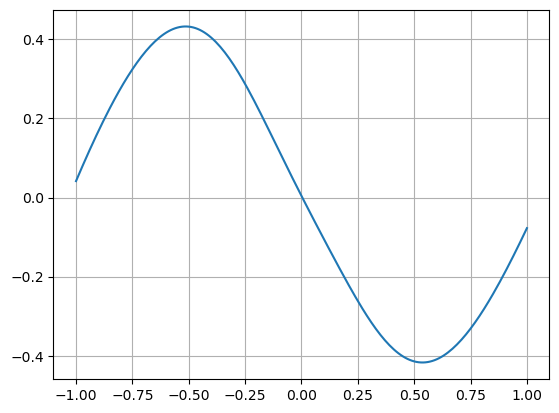

In [63]:
#y_locations_test = model((input1[1].to(device)).expand(len(input2_physics),-1),input2_physics.to(device))
time_asked = 0.9
test_input_2 = torch.concat([test_output_loc.unsqueeze(-1) ,time_asked*torch.ones_like(test_output_loc).unsqueeze(-1)],dim=1)
y_locations_test = model((test_model_input.to(device)),test_input_2.to(device))
plt.plot(test_output_loc.cpu().detach().numpy(),y_locations_test.cpu().detach().numpy()) 
plt.grid()       

In [80]:
input_time.size(0)

3000

In [81]:
input2_BC1 = torch.cat((torch.zeros(input_time.size(0),1),input_time),-1).to(device)

In [82]:
target_BC1 = torch.zeros(input_time.size(0))

In [83]:
input2.size()

torch.Size([3000, 2])

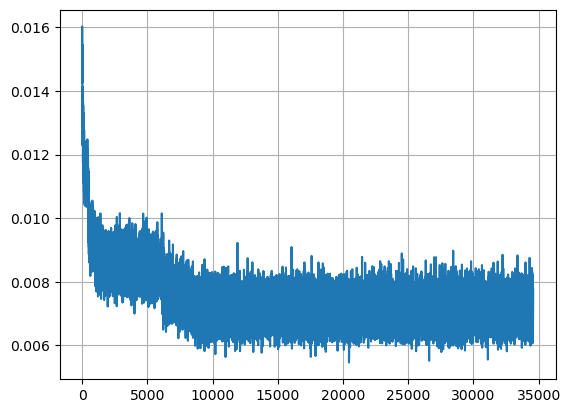

In [37]:
plt.plot(loss_rec)#[1000:])
plt.grid()

In [139]:
# model(y,torch.tensor([0,0]))